# Evaluation

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [82]:
import pandas as pd
import os
from scoring import linkages
import seaborn as sns
import matplotlib.pyplot as plt
from more_itertools import chunked
import numpy as np

In [83]:
EVAL_DIR = os.path.join("..", "eval")

In [214]:
def load_solutions(ns):
    dfs = []
    for n in ns:
        try:
            temp3 = pd.read_csv(f"{EVAL_DIR}/{n}_single.csv")  # TODO
            temp3["approach"] = "ga"
        except FileNotFoundError:
            temp3 = pd.DataFrame()
            print("Didn't find new solutions")
        # df = pd.concat([temp1, temp2, temp3]).sort_values("single", ascending=False).reset_index(drop=True)
        df = (
            temp3.sort_values("single_log", ascending=False)
            .iloc[:, 1:]
            .reset_index(drop=True)
        )
        # dfs.append(df.head(n * 2))
        dfs.append(df.head(5))
    return dfs

In [215]:
ns = list(range(4, 21))
dfs = load_solutions(ns)

In [216]:
s = dfs[6].iloc[0]
s

0                     ALK
1                    CD99
2                    GPC2
3                    HM13
4                   ISLR2
5                   KCNQ2
6                   L1CAM
7                  MARCH6
8                   NCAM1
9                    PTK7
single          46.753507
median          87.766217
average         90.791708
quartile        71.515145
quantile         53.33642
single_log       1.607299
median_log       2.656837
average_log      2.686655
quartile_log      2.33324
quantile_log     1.880695
approach               ga
Name: 0, dtype: object

In [92]:
from scoring import Scoring
from plotting import Plotting

S = Scoring()
P = Plotting(S)

In [147]:
sol = s[0:10].values

<AxesSubplot:title={'center':'10 selected antigens: ALK, CD99, GPC2, HM13, ISLR2, KCNQ2, L1CAM, MARCH6, NCAM1, PTK7'}, xlabel='tissue', ylabel='log2(TPM sum)'>

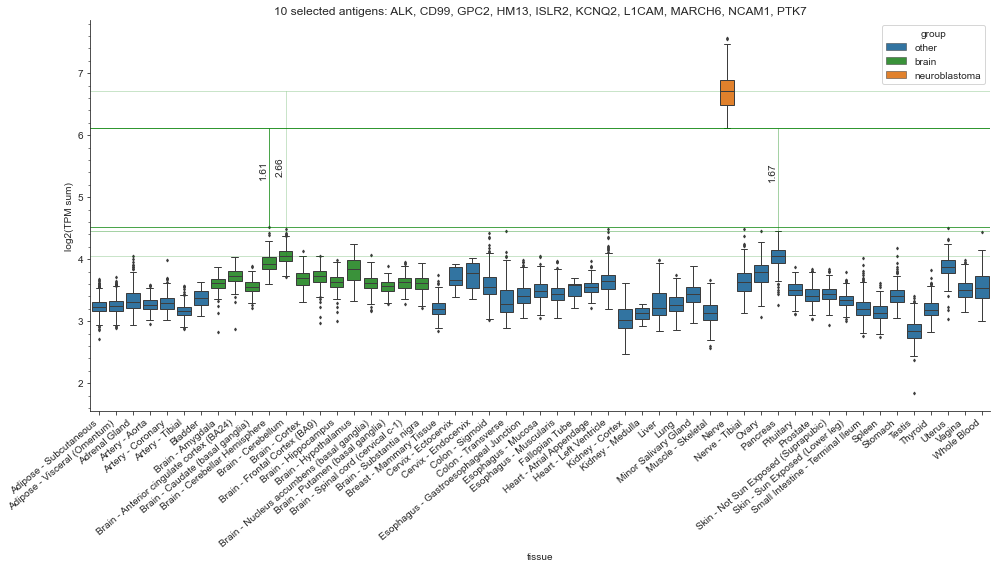

In [148]:
sns.set_style("ticks")
P.boxplot(sol, log=True)

In [49]:
import sys

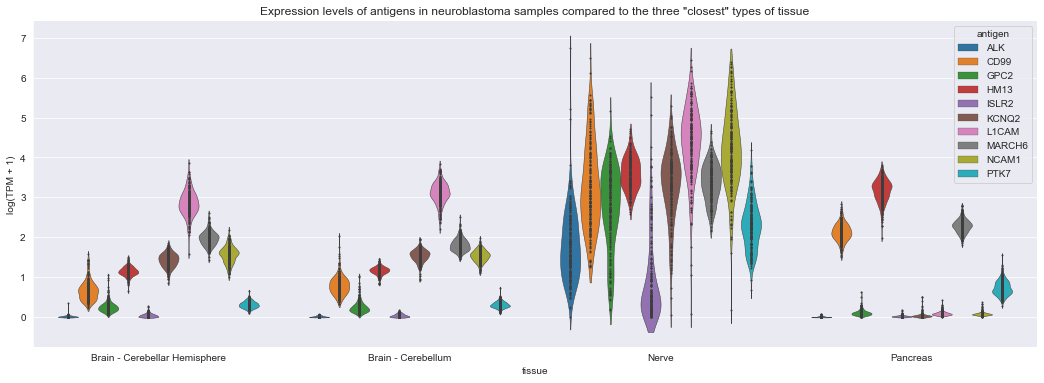

In [217]:
d = pd.melt(
    S.df[["disease", "tissue"] + list(sol)],
    id_vars=["disease", "tissue"],
    var_name="antigen",
)

show = [
    "Nerve",
    S.get_worst_tissue(sol, "max"),
    S.get_worst_tissue(sol, "median"),
    S.get_worst_tissue(sol, "outlier_upper"),
]
d = d[d.tissue.isin(show)]
d["scaled"] = np.log2(d["value"] + 1)
plt.figure(figsize=(18, 6))
g = sns.violinplot(
    data=d,
    x="tissue",
    y="scaled",
    hue="antigen",
    dodge=True,
    inner="point",
    linewidth=0.5,
    cut=True,
    alpha=0.5,
    # bw=0.2,
    scale="width",
    palette=sns.color_palette() + sns.color_palette("pastel"),
)
g.set_ylabel("log(TPM + 1)")
g.set_title(
    'Expression levels of antigens in neuroblastoma samples compared to the three "closest" types of tissue'
)
sns.despine()
# g.get_figure().savefig(EVAL_DIR + "violin10.svg", format="svg", bbox_inches="tight")
# g.set(ylim=(0, 8))
# _ = g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")

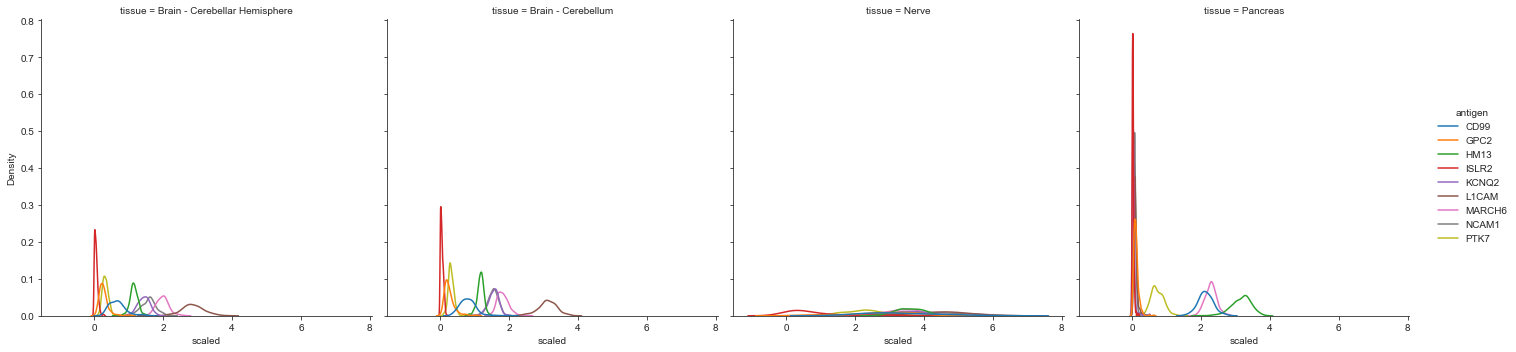

In [134]:
sns.displot(
    data=d[d.antigen != "ALK"], x="scaled", hue="antigen", col="tissue", kind="kde"
)

In [218]:
def enc(orig, n_antigens):
    ks = linkages + ["approach"]  # 'run_id',
    ks = orig.columns.intersection(ks)
    extra = orig[ks]
    ag = orig.drop(ks, axis=1).reset_index()
    ag = ag.reset_index()
    ag = pd.melt(
        ag,
        id_vars="index",
        value_vars=[str(i) for i in range(n_antigens)],
        value_name="antigen",
    ).drop("variable", axis=1)
    ag["cnt"] = 1
    p = (
        pd.pivot_table(
            ag, index="index", columns=["antigen"], values="cnt", aggfunc="count"
        )
        .fillna(0)
        .join(extra)
    )
    p["n"] = n_antigens
    return p

In [219]:
encs = []
for n in ns:
    encs.append(enc(dfs[0], n))
    del dfs[0]

In [220]:
ev = pd.concat(encs).fillna(0)
ev = ev.reset_index(drop=False).rename({"index": "rank"}, axis=1)
ev.head()

,rank,CHRNA7,CHRNB4,CLN3,GDPD1,GRM8,ISLR2,LRRTM4,NRXN1,VEZT,...,FAP,FKRP,IGSF3,LAIR1,SEMA5B,CACNA2D3,SLC44A5,GPR1,KREMEN2,THSD7A
0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


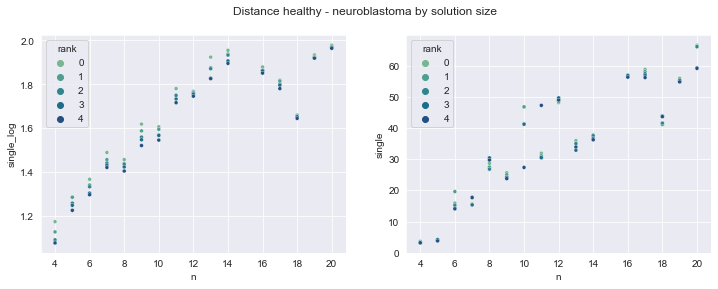

In [241]:
sns.set_style("darkgrid")
ev = ev[ev.n != 15]
# ev = ev[ev.n != 19]
# ev = ev[ev.n != 20]
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
pal = sns.color_palette("crest", n_colors=5)
fig.suptitle("Distance healthy - neuroblastoma by solution size")
sns.scatterplot(
    x="n",
    y="single_log",
    data=ev,
    ax=axs[0],
    s=15,
    hue="rank",
    palette=pal,
    legend=True,
)
# sns.lineplot(x="n", y="single_log", data=ev, ax=axs[0], err_style=None)

sns.scatterplot(x="n", y="single", data=ev, ax=axs[1], s=15, hue="rank", palette=pal)
# axs[1].legend(bbox_to_anchor=(1.2, 0.75), loc="upper right", borderaxespad=0)
# sns.scatterplot(
#   data=ev,
#  x="single",
# y="single_log",
# hue="n",
# ax=axs[2],
# palette=sns.color_palette("crest", as_cmap=True),
# )
fig.savefig("../evaldistn.svg", format="svg", bbox_inches="tight")
# sns.lineplot(x="n", y="single", data=ev, ax=axs[1], err_style=None)

In [222]:
a = ev[ev.n.isin(range(15))]
b = ev[~ev.n.isin(range(15))]
display(a[["single_log", "n"]].corr())
display(b[["single_log", "n"]].corr())
display(ev[["single", "n"]].corr())
display(ev[["single", "single_log"]].corr())

,single_log,n
single_log,1.000000,0.984973
n,0.984973,1.000000


,single_log,n
single_log,1.000000,0.427925
n,0.427925,1.000000


,single,n
single,1.000000,0.912523
n,0.912523,1.000000


,single,single_log
single,1.000000,0.875346
single_log,0.875346,1.000000


<AxesSubplot:xlabel='single', ylabel='single_log'>

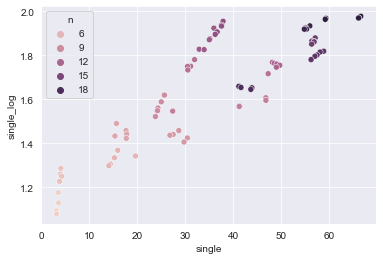

In [223]:
sns.scatterplot(data=ev, x="single", y="single_log", hue="n")

In [236]:
gs = ev.drop(ev.columns.intersection(linkages), axis=1)  # + ['rank']
gs = gs.drop("rank", axis=1)
grp = gs.groupby("n").sum()
m = pd.melt(grp.reset_index(), id_vars="n", value_name="cnt", var_name="antigen")
m.cnt = m.cnt / 5  # (m.n * 2)
m.head()

,n,antigen,cnt
0,4,CHRNA7,0.6
1,5,CHRNA7,0.0
2,6,CHRNA7,0.0
3,7,CHRNA7,0.0
4,8,CHRNA7,0.0


<AxesSubplot:xlabel='cnt', ylabel='Count'>

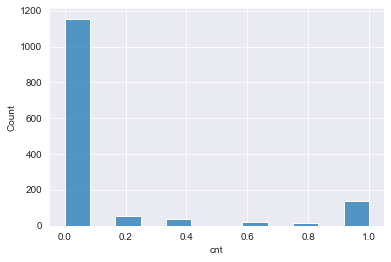

In [237]:
sns.histplot(m.cnt)

80


<AxesSubplot:xlabel='cnt', ylabel='Count'>

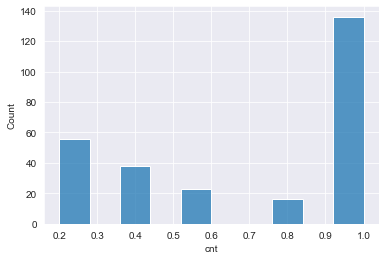

In [238]:
f = m[m.cnt > 0]
m = m[m.antigen.isin(f.antigen.unique())]
ags = f.antigen.unique()
ags = np.array(sorted(ags))[(f[f.cnt > 0].groupby("antigen").size() > 1)]
print(len(f.antigen.unique()))
sns.histplot(f.cnt)

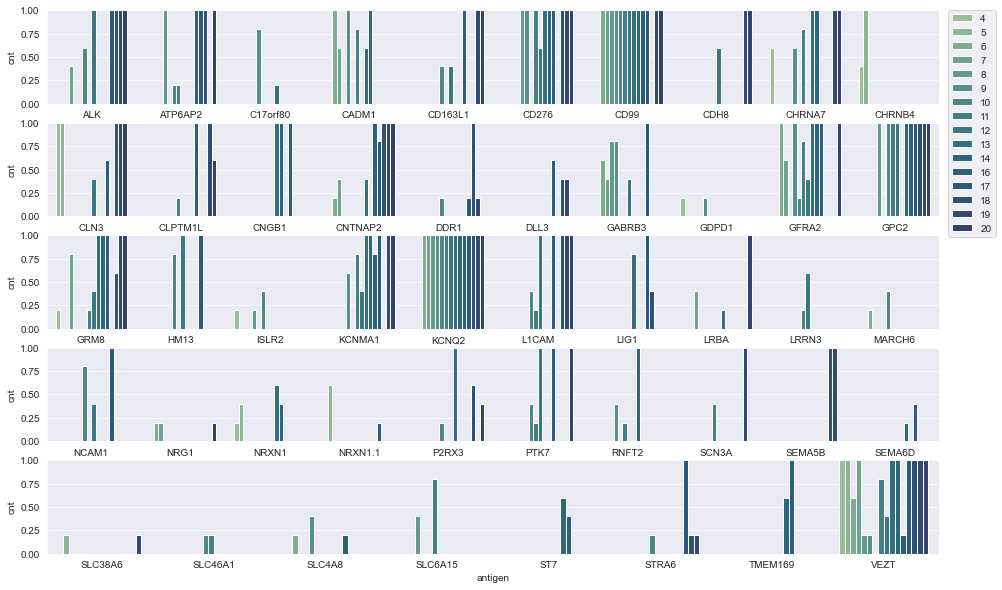

In [240]:
batches = list(chunked(sorted(ags), 10))
fig, axs = plt.subplots(len(batches), 1, figsize=(16, 2 * len(batches)))
leg = True
for batch, ax in zip(batches, axs):
    batch = m[m.antigen.isin(batch)].sort_values(by="antigen").reset_index()
    g = sns.barplot(
        data=batch,
        x="antigen",
        hue="n",
        y="cnt",
        ax=ax,
        palette=sns.color_palette("crest", len(m.n.unique())),
    )
    if not leg:
        g.legend_.remove()
    else:
        leg = False
        ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0)
    g.set(ylim=(0, 1))
# _ = g.set_xticklabels(g.get_xticklabels(), rotation=45)

In [ ]:
x = ags.rename('c').to_frame().reset_index()

In [ ]:
a = m[m.n==5]
a

In [ ]:
m[m.n == 13]

In [ ]:
m = m.reset_index(drop=True)
m

In [ ]:
sns.catplot(m, x='antigen', y='cnt', kind="bar",aspect=3)

In [ ]:
df_plt = grp[ags.index].reset_index()
df_plt = pd.melt(df_plt, id_vars='n', var_name='antigen', value_name='proportion')
df_plt

In [ ]:
sns.lineplot(data=df_plt, x='n', y='proportion', hue='antigen')

In [ ]:
sns.displot(
    df, x="flipper_length_mm", col="species", row="sex",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

In [ ]:
encs[0]

In [ ]:
import seaborn as sns

sns.

In [ ]:
dfs = load.load_solutions([5, 10])
a = dfs[0]  # .sort_values("quantile", ascending=False)
a

In [ ]:
plotting.boxplot(a.iloc[0, :5], log=True)

In [ ]:
dfs[0].approach.unique()

In [ ]:
import pandas as pd


def x_best(idx, n):
    sols = dfs[idx].iloc[:, :n]
    sel = (
        dfs[idx]
        .loc[
            sols.apply(lambda x: su.score(x, "single_log", True), axis=1)
            .nlargest(10)
            .index
        ]
        .iloc[:, :n]
    )
    sel = pd.concat(
        [
            sel,
            sel.apply(lambda x: su.score(x), axis=1),
            sel.apply(lambda x: su.score(x, log=True), axis=1),
        ],
        axis=1,
    ).join(dfs[0].run_id)
    return sel


def best(idx, n):
    b = x_best(idx, n).iloc[0, :n]
    return b


def best_score(idx, n):
    b = x_best(idx, n).iloc[0]["single_log"]
    return b

In [ ]:
best_score(1, 2)

In [ ]:
plotting.boxplot(best(8, 9))

In [ ]:
scores = [best_score(idx, idx + 1) for idx in range(10)]
scores

In [ ]:
import matplotlib.pyplot as plt

plt.xticks(range(1, 11))
plt.grid(True)
plt.xlabel("Solution size")
plt.plot(range(1, 11), scores)

In [ ]:
import pandas as pd

s = Scoring(df_unscaled, "neuroblastoma")
pd.concat(
    [
        sel1,
        sel1.apply(lambda x: s.score(x), axis=1),
        sel1.apply(lambda x: s.score(x, log=True), axis=1),
    ],
    axis=1,
).join(dfs[0].run_id)
pd.concat(
    [
        sel2,
        sel2.apply(lambda x: s.score(x), axis=1),
        sel2.apply(lambda x: s.score(x, log=True), axis=1),
    ],
    axis=1,
)

In [ ]:
plotting.boxplot(sel1.iloc[0])

In [ ]:
d = df_unscaled[["tissue"] + list(best(4, 5))].loc[
    df_unscaled.tissue == "Nerve - Tibial"
]
d = d.melt(id_vars="tissue")
d

In [ ]:
d[d.variable == "KCNQ2"]

In [ ]:
import seaborn as sns

plt.figure(figsize=(5, 7))
sns.boxplot(data=d, x="variable", y="value")

In [ ]:
sel = ["CHRNA7", "CLN3", "DCC", "SLC24A1", "VEZT"]
sel2 = ["CD99", "KCNQ2", "SMPD4", "VEZT"]

In [ ]:
s = Scoring(df_un

In [ ]:
sel = dfs[0].iloc[0, :5].values
Scoring(df_unscaled).score(sel, log=True)
plotting.boxplot(sel)

In [ ]:
import numpy as np

# ld = df_unscaled.copy()
# ld.iloc[:, 3:] = np.log2(ld.iloc[:, 3:])
sel

Scoring(ld).score(sel[0:5], log=False).single,
Scoring(ld).score(sel, log=False).single
# Plotting(ld, Scoring(ld)).boxplot(sel)

In [ ]:
plotting = Plotting(df, Scoring(df))
plotting.boxplot(df_genes.columns)